#  Dealiasing

Dealiases a radar volume for use in multidop

In [226]:
import pyart
from matplotlib import pyplot as plt
from scipy import ndimage
import shutil, os
from datetime import timedelta, datetime
import numpy as np
import re
import time
import glob
from copy import deepcopy
from IPython.display import Image, display
%matplotlib inline
from mpl_toolkits import basemap
from netCDF4 import Dataset

In [227]:
input_file = '/home/rjackson/data/radar/Gunn_pt_20051224141001ppi.nc'
prev_file = '/home/rjackson/data/radar/berr/BerrimaVol20060123_003004deal.cf'

data_path_berr = '/home/rjackson/data/radar/berr/uncorrected/'
out_path_berr = '/home/rjackson/data/radar/berr/'
radar_image_path = '/home/rjackson/plots/berr_deal/'
output_file = '/home/rjackson/data/radar/berr/BerrimaVol20060123_004003_deal.uf'

sounding_input_file = '/home/rjackson/data/soundings/twpsondewnpnC3.b1.20051224.111600.custom.cdf'
data_path_sounding = '/home/rjackson/data/soundings/'

# Input the range of dates and time wanted for the collection of images
start_year = 2006
start_day = 23
start_month = 1
start_hour = 13
start_minute = 00
start_second = 0

end_year = 2006
end_month = 1
end_day = 23
end_hour = 18
end_minute = 00
end_second = 0


In [228]:
radar = pyart.io.read(input_file)
radar.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	positive: up
	standard_name: Altitude
	units: meters
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float32 and shape: (4131,)>
	units: degrees
	comment: Azimuth of antenna relative to true north
	standard_name: beam_azimuth_angle
	axis: radial_azimuth_coordinate
	long_name: azimuth_angle_from_true_north
elevation:
	data: <ndarray of type: float32 and shape: (4131,)>
	units: degrees
	comment: Elevation of antenna relative to the horizontal plane
	standard_name: beam_elevation_angle
	axis: radial_elevation_coordinate
	long_name: elevation_angle_from_horizontal_plane
fields:
	spectrum_width:
		data: <ndarray of type: float32 and shape: (4131, 480)>
		units: meters_per_second
		standard_name: doppler_spectrum_width
		long_name: Doppler spectrum width
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	differential_phase:
		data: <ndarray of type: float32 and shape: (4

In [229]:
Sounding_netcdf = Dataset(sounding_input_file, mode='r')

# Convert timestamps to datetime format
Time = Sounding_netcdf.variables['time_offset'][:]
base_time = Sounding_netcdf.variables['base_time'][:]
alt = Sounding_netcdf.variables['alt'][:]
u = Sounding_netcdf.variables['u_wind'][:]
v = Sounding_netcdf.variables['v_wind'][:]
t = Sounding_netcdf.variables['tdry'][:]
v = v[u > -75]
alt = alt[u > -75]
u = u[u > -75]
steps = np.floor(len(u)/50)
wind_profile = pyart.core.HorizontalWindProfile.from_u_and_v(alt[0::steps],
                                                             u[0::steps],
                                                             v[0::steps])

print(wind_profile.u_wind)
## 4DD expects speed, direction but HorizontalWindProfile outputs u_wind, v_wind
wind_profile.u = wind_profile.u_wind
wind_profile.v = wind_profile.v_wind
Sounding_netcdf.close()

[3.673722982406616 4.635919570922852 -4.021447637114761e-07
 -4.649263381958008 -6.311611175537109 -9.66308879852295
 -13.448628425598145 -17.899999618530273 -17.597320556640625
 -15.162973403930664 -11.325288772583008 -10.958383560180664
 -11.380026817321777 -9.508899688720703 -9.678834915161133
 -7.464168548583984 -4.659082412719727 -4.622169494628906
 -4.028686046600342 -4.993147850036621 -4.531538963317871
 -3.2370288372039795 -2.374737501144409 -2.231680154800415
 -2.36403226852417 -0.8282209634780884 -1.6263456344604492
 -1.5897576808929443 -2.3618383407592773 -2.6615569591522217
 -1.7000000476837158 -1.034774661064148 -0.1849673092365265
 0.5839453935623169 1.3717422485351562 -0.6890933513641357
 -1.8809127807617188 -2.7704765796661377 -4.305785179138184
 -9.010671615600586 -15.621627807617188 -18.088199615478516
 -19.666784286499023 -18.2992000579834 -13.232093811035156
 -10.877830505371094 -14.8439302444458 -16.541086196899414
 -21.295059204101562 -16.432878494262695 -6.406858

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3117: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3172: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]


(-150, 150)

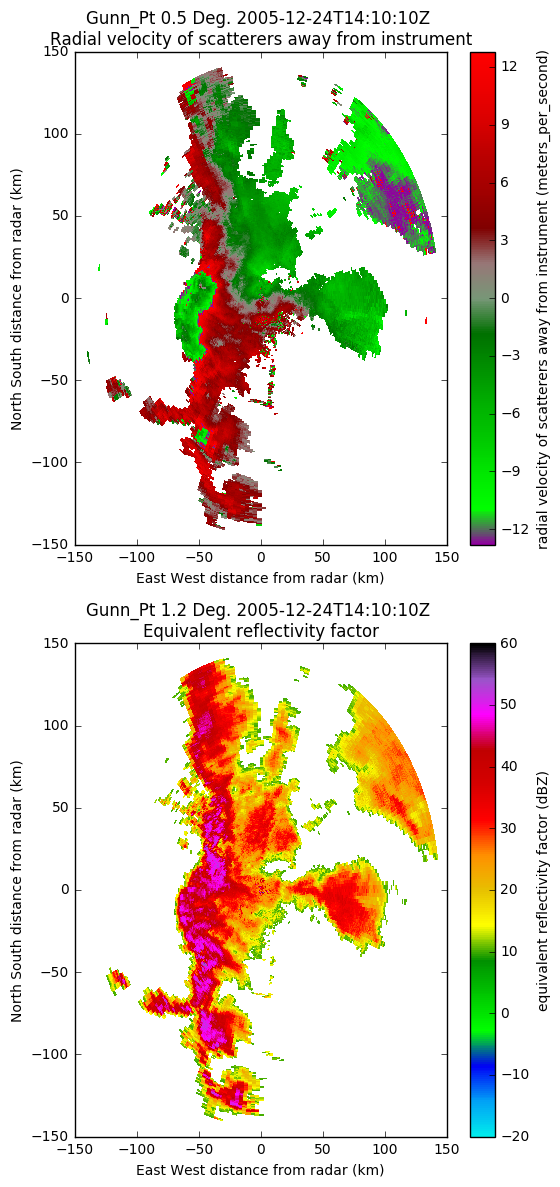

In [235]:
display = pyart.graph.RadarMapDisplay(radar)


gatefilter = pyart.correct.GateFilter(radar)
gatefilter.exclude_below('reflectivity', 10)

plt.figure(figsize=(6,14))
plt.subplot(211)
display.plot_ppi('velocity', sweep=0,
                 vmin=-12.8, vmax=12.8, cmap=pyart.graph.cm.NWSVel,
                 gatefilter=gatefilter)
plt.xlim([-150,150])
plt.ylim([-150,150])

plt.subplot(212)
display.plot_ppi('reflectivity', sweep=1,
                 vmin=-20, vmax=60, cmap=pyart.graph.cm.NWSRef,
                 gatefilter=gatefilter)
plt.xlim([-150,150])
plt.ylim([-150,150])

In [240]:
gatefilter = pyart.correct.GateFilter(radar)
gatefilter.exclude_below('reflectivity', 10)
gatefilter.exclude_masked('velocity')
gatefilter.exclude_invalid('velocity')
gatefilter.exclude_masked('reflectivity')
gatefilter.exclude_invalid('velocity')
gatefilter.exclude_above('reflectivity', 80)
gatefilter.exclude_below('velocity', -75)
gatefilter.exclude_above('velocity', 75)
nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]
corrected_velocity_4dd = pyart.correct.dealias_fourdd(radar,
                                                      vel_field='velocity',
                                                      sounding_heights = wind_profile.height,
                                                      sounding_wind_speeds = wind_profile.speed,
                                                      sounding_wind_direction = wind_profile.direction,
                                                      keep_original=False,
                                                      gatefilter=gatefilter,
                                                      filt=1,
                                                      ba_mincount=5,
                                                      ba_edgecount=3,
                                                      )
radar.add_field_like('velocity', 
                     'corrected_velocity', 
                     corrected_velocity_4dd['data'],
                     replace_existing=True)

radar.add_field('sim_velocity',
                pyart.util.simulated_vel_from_profile(radar, wind_profile),
                replace_existing=True)

corrected_velocity_region = pyart.correct.dealias_region_based(radar,
                                                               vel_field='velocity',
                                                               gatefilter=gatefilter,
                                                               keep_original=False,
                                                               rays_wrap_around=True,
                                                               centered=True,
                                                               interval_splits=3,
                                                               skip_between_rays=100,
		                                                       skip_along_ray=1000,
                                                               valid_min=-75,
                                                               valid_max=75,
                                                               nyquist_velocity=nyq)
radar.add_field_like('velocity', 
                     'corrected_velocity_region', 
                     corrected_velocity_region['data'],
                     replace_existing=True)

difference = (radar.fields['corrected_velocity']['data']-radar.fields['corrected_velocity_region']['data'])/nyq
radar.add_field_like('velocity', 
                     '4dd_minus_region_based', 
                     difference,
                     replace_existing=True)

/home/rjackson/.local/lib/python3.5/site-packages/pyart/correct/dealias.py:207: DeprecationWarning: Sounding arguments are deprecated please use the sonde_profile argument
  warnings.warn(msg, DeprecationWarning)


## Plot the sounding

I use this as a way to verify that the final dealiased results make sense in terms of the wind directions. 
I noticed that phase unwrapping and 4DD will give winds in the opposite directions. The sounding below gives winds going to the west-northwest, so the corrected velocities should, on average, reflect that. 

(0, 10000)

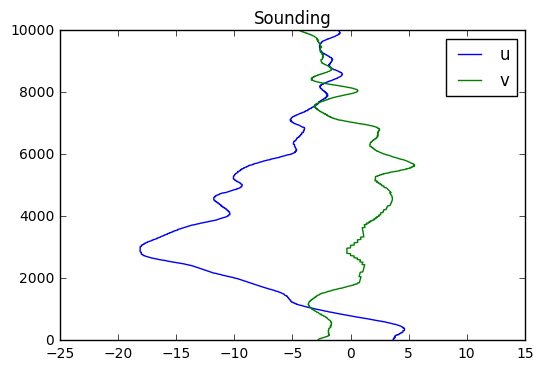

In [232]:
plt.plot(u,alt)
plt.plot(v,alt)
plt.legend(['u','v'])
plt.title('Sounding')
plt.ylim([0, 10000])

## Compare region based and phase unwrapping

Compare region based and phase unwrapping. Region based algorithm sometimes unfolds velocities incorrectly by a nyquist interval. 

(-150, 150)

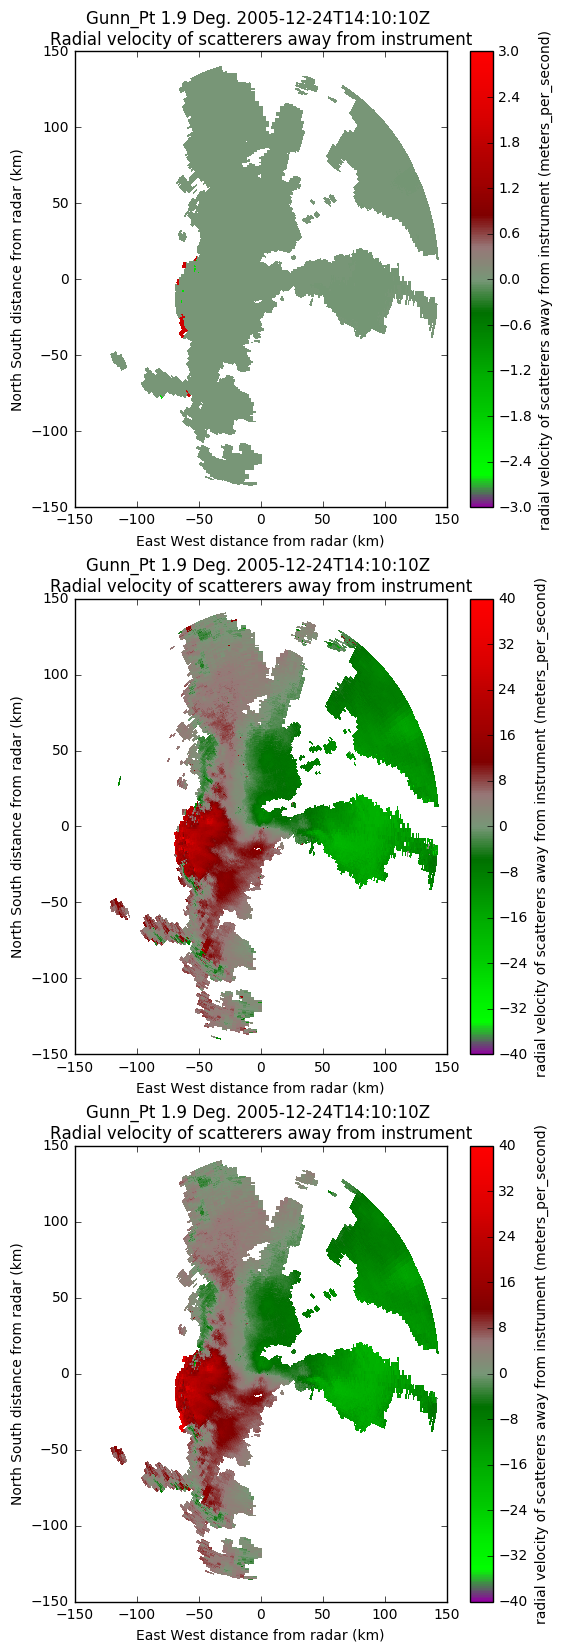

In [241]:
plt.figure(figsize=(6,20))

plt.subplot(311)
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('4dd_minus_region_based', sweep=2,
                 vmin=-3, vmax=3, cmap=pyart.graph.cm.NWSVel,
                 gatefilter=gatefilter)
plt.xlim([-150,150])
plt.ylim([-150,150])

sim_vel = radar.fields['sim_velocity']['data'][:]
corr_vel = radar.fields['corrected_velocity_region']['data'][:]
radar.fields['corrected_velocity_region']['data'] = corr_vel


radar.fields['corrected_velocity_region']['data'] = corr_vel
sweep_slice = enumerate(radar.iter_slice())

#scorr += global_fold * nyquist_interval
plt.subplot(312)
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('corrected_velocity_region', sweep=2,
                 vmin=-40, vmax=40, cmap=pyart.graph.cm.NWSVel,
                 gatefilter=gatefilter)
plt.xlim([-150,150])
plt.ylim([-150,150])
plt.subplot(313)
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('corrected_velocity', sweep=2,
                 vmin=-40, vmax=40, cmap=pyart.graph.cm.NWSVel,
                 gatefilter=gatefilter)
plt.xlim([-150,150])
plt.ylim([-150,150])

## Calculate gradient of dealiased image to remove badly folded time periods


In [213]:
gradient = pyart.config.get_metadata('velocity')
gradients = np.ma.array(np.gradient(radar.fields['Vel']['data'],
                                    edge_order=2))
gradients = np.ma.masked_where(gradients < -31000, gradients)
gradients = gradients/(radar.instrument_parameters['nyquist_velocity']['data'][1])
corr_vel = radar.fields['corrected_velocity']['data']
gradient['data'] = gradients[0]
gradient['standard_name'] = 'gradient_of_corrected_velocity_wrt_azimuth'
radar.add_field('gradient_wrt_angle',
                 gradient,
                 replace_existing=True)

gradient = pyart.config.get_metadata('velocity')
gradient['data'] = gradients[1]
gradient['standard_name'] = 'gradient_of_corrected_velocity_wrt_range'
radar.add_field('gradient_wrt_range',
                 gradient,
                 replace_existing=True)


plt.figure(figsize=(8,20))
plt.subplot(311)
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('gradient_wrt_range', vmin=-0.5, vmax=0.5)
plt.xlim([-150,150])
plt.ylim([-150,150])

plt.subplot(312)
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('gradient_wrt_angle', vmin=-0.5, vmax=0.5)
plt.xlim([-150,150])
plt.ylim([-150,150])
plt.title('Gradient of velocity w.r.t. azimuth angle')

diff = radar.fields['corrected_velocity_region']['data']/radar.fields['sim_velocity']['data']
diff = diff/(radar.instrument_parameters['nyquist_velocity']['data'][1])     
radar.add_field_like('sim_velocity', 
                     'velocity_diff', 
                     diff, 
                     replace_existing=True)    
plt.subplot(313)
display.plot_ppi('velocity_diff',
                vmin=-3, vmax=3)
plt.xlim([-150,150])
plt.ylim([-150,150])
plt.title('Corrected velocity-simulated velocity normalized by Vn')
intervals_start = np.arange(-5.5, 5.5, 1.0)
intervals_end = np.arange(-4.5, 6.5, 1.0)
intervals = np.zeros((len(intervals_start),2))
intervals[:,0] = intervals_start
intervals[:,1] = intervals_end

KeyError: 'Vel'

[ 10.  11.]


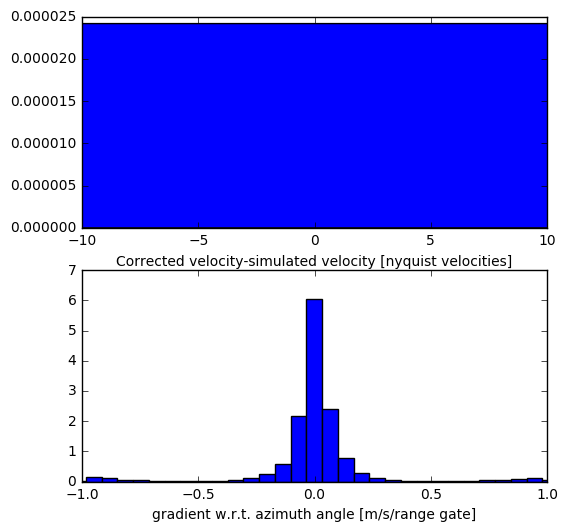

In [193]:
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

X = diff[diff > -100]
X = X.flatten()

x_grid = np.linspace(-10, 10, 100)
pdf = kde_scipy(X, x_grid, bandwidth=0.01)
   
plt.figure(figsize=(6,6))
plt.subplot(211)
bins, centers = np.histogram(diff[diff > -100])
plt.hist(diff[diff > -100], normed=1, bins=50)
#plt.plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
plt.xlim([-10,10])
plt.xlabel('Corrected velocity-simulated velocity [nyquist velocities]')
# Find local minima and split data at those minima
#minima = argrelextrema(pdf, np.less)
#plt.scatter(x_grid[minima[0]],pdf[minima[0]])
plt.subplot(212)
bins, centers = np.histogram(gradients[gradients > -100])
plt.hist(gradients[gradients > -100], normed=1, bins=1200)
plt.xlim([-1,1])
plt.xlabel('gradient w.r.t. azimuth angle [m/s/range gate]')

# Split up data according to minima
boundaries = x_grid[minima[0]]
group = np.ma.zeros(diff.shape)
i = 1
for bounds in boundaries:
    indicies = np.where(np.logical_and(group == 0, diff < bounds))
    group[indicies] = i
    i = i + 1
group_dict = pyart.config.get_metadata('velocity')
group_dict['data'] = group
group_dict['long_name'] = 'Group #'
radar.add_field('group',
                 group_dict,
                 replace_existing=True) 
mean_diffs = np.zeros((len(boundaries),))
group_bins = np.zeros((len(boundaries),))
for i in range(0, len(boundaries)):
    mean_diffs[i] = np.ma.median(diff[group==i])
    group_bins[i] = i
indicies = np.where(np.logical_and(mean_diffs < 0.5,mean_diffs > -0.5))
print(group_bins[indicies[0]])

(-150, 150)

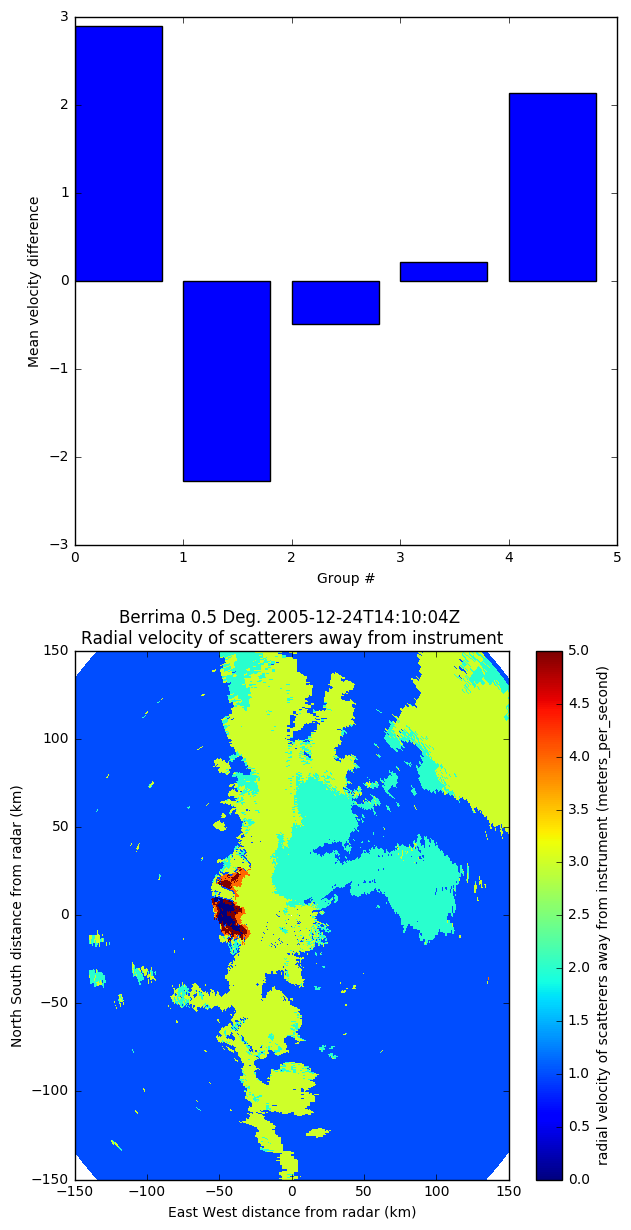

In [131]:
plt.figure(figsize=(7,15))
plt.subplot(211)
plt.bar(range(0, len(boundaries)), mean_diffs)
plt.xlabel('Group #')
plt.ylabel('Mean velocity difference')

plt.subplot(212)
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('group')
plt.xlim([-150,150])
plt.ylim([-150,150])

## Display data with gatefilter

/home/rjackson/.local/lib/python3.5/site-packages/pyart/correct/despeckle.py:201: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  old_labs = np.unique(labels[i2][labels[i2] > 0])
/home/rjackson/.local/lib/python3.5/site-packages/pyart/correct/despeckle.py:204: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  indices = np.where(labels[i2] == lab)
/home/rjackson/.local/lib/python3.5/site-packages/pyart/correct/despeckle.py:207: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  labels = labels[0:i2]


(-150, 150)

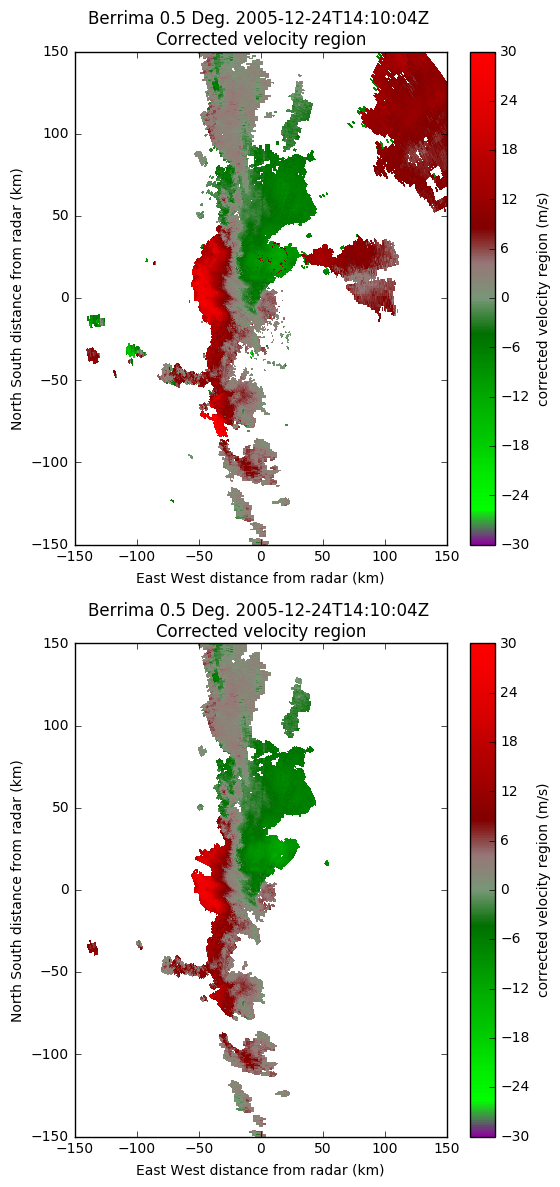

In [173]:
gatefilter = pyart.correct.GateFilter(radar)

plt.figure(figsize=(6,14))
plt.subplot(211)
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('corrected_velocity_region', sweep=0,
                 vmin=-30, vmax=30, cmap=pyart.graph.cm.NWSVel,
                 gatefilter=gatefilter)
plt.xlim([-150,150])
plt.ylim([-150,150])

gatefilter = pyart.correct.GateFilter(radar)
gatefilter.exclude_above('4dd_minus_region_based', 0.05)
gatefilter.exclude_below('4dd_minus_region_based', -0.05)
gatefilter = pyart.correct.despeckle_field(radar, 
                                           'corrected_velocity',
                                           gatefilter=gatefilter,
                                           )
plt.subplot(212)
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('corrected_velocity_region', sweep=0,
                 vmin=-30, vmax=30, cmap=pyart.graph.cm.NWSVel,
                 gatefilter=gatefilter)
plt.xlim([-150,150])
plt.ylim([-150,150])

## Batch process dealiasing with images

In [7]:
# get_radar_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_radar_times_berr(start_year, start_month, start_day,
                        start_hour, start_minute, end_year,
                        end_month, end_day, end_hour, 
                        end_minute, minute_interval=5):

    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
    
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path_berr +
                      'BerrimaVol' +
                      year_str +
                      month_str +
                      day_str +
                      '_*.uf')
    
    
        print('Looking for files with format ' + format_str)
          
        data_list = glob.glob(data_path_berr +
                              'BerrimaVol' +
                              year_str +
                              month_str +
                              day_str +
                              '_*.uf')
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-18:-3]
        
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[9:11]
        minute_str = date_str[11:13]
        second_str = date_str[13:15]
               
        
        
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
    
    
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
           
            
            
    
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_radar_from_berr(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path_berr +
                     'BerrimaVol' +
                     year_str +
                     month_str +
                     day_str +
                     '_' +
                     hour_str +
                     minute_str +
                     second_str +
                     '.uf')
    print(file_name_str)    
    radar = pyart.io.read(file_name_str)
    return radar

def save_radar_deal_berr(time, radar):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (out_path_berr +
                     'BerrimaVol' +
                     year_str +
                     month_str +
                     day_str +
                     '_' +
                     hour_str +
                     minute_str +
                     second_str +
                     '_deal.cf')
    pyart.io.write_cfradial(file_name_str, radar)


def load_radar_deal_berr(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (out_path_berr +
                     'BerrimaVol' +
                     year_str +
                     month_str +
                     day_str +
                     '_' +
                     hour_str +
                     minute_str +
                     second_str +
                     '_deal.cf')
    pyart.io.read(file_name_str, radar)
    return radar

# get_sounding_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of sounding times between start_time and end_time. 
def get_sounding_times(start_year, start_month, start_day,
                       start_hour, start_minute, end_year,
                       end_month, end_day, end_hour, 
                       end_minute, minute_interval=5):

    from datetime import timedelta, datetime
    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )
    deltatime = end_time - start_time
  
    if(deltatime.seconds > 0 or deltatime.minutes > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load sounding files for ' + str(no_days) + ' days')
    
    # Find the list of files for each day
    cur_time = start_time

    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path_sounding +
                      'twpsondewnpnC3.b1.' +
                      year_str +
                      month_str +
                      day_str +
                      '*custom.cdf')
    
          
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
        
   
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-26:-11]  
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[9:11]
        minute_str = date_str[11:13]
        second_str = date_str[13:15]
                
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
    
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
               
    return time_list_final

# Get a sounding object given a time period in the CPOL dataset
def get_sounding(time):
    from datetime import timedelta, datetime
    from netCDF4 import Dataset
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path_sounding +
                     'twpsondewnpnC3.b1.' +
                     year_str +
                     month_str +
                     day_str +
                     '.' +
                     hour_str +
                     minute_str +
                     second_str +
                     '.custom.cdf')
    sounding = Dataset(file_name_str, mode='r')
    return sounding

First successfully dealiased frame = 01-21 01:10

In [28]:
times_berr = get_radar_times_berr(start_year, start_month, start_day,
                                  start_hour, start_minute, end_year,
                                  end_month, end_day, end_hour, 
                                  end_minute, minute_interval=1)

plt.figure(figsize=(6,6))
last_Radar = []

for times in times_berr:
    one_day_ago = times-timedelta(days=1, minutes=1)
    sounding_times = get_sounding_times(one_day_ago.year,
                                        one_day_ago.month,
                                        one_day_ago.day,
                                        one_day_ago.hour,
                                        one_day_ago.minute,
                                        times.year,
                                        times.month,
                                        times.day,
                                        times.hour,
                                        times.minute,
                                        minute_interval=60)
    sounding_time = sounding_times[len(sounding_times)-1]
    Sounding_netcdf = get_sounding(sounding_time)
    print(sounding_time)
    # Load sounding data
    Time = Sounding_netcdf.variables['time_offset'][:]
    base_time = Sounding_netcdf.variables['base_time'][:]
    alt = Sounding_netcdf.variables['alt'][:]
    u = Sounding_netcdf.variables['u_wind'][:]
    v = Sounding_netcdf.variables['v_wind'][:]
    t = Sounding_netcdf.variables['tdry'][:]
    spd = Sounding_netcdf.variables['wspd'][:]
    deg = Sounding_netcdf.variables['deg'][:]
    spd = spd[u > -75]
    deg = deg[u > -75]
    v = v[u > -75]
    alt = alt[u > -75]
    u = u[u > -75]
    
    
    steps = np.floor(len(u)/50)
    #steps=5
    wind_profile = pyart.core.HorizontalWindProfile.from_u_and_v(alt[0::steps],
                                                                 u[0::steps],
                                                                 v[0::steps])
    
    ## 4DD expects speed, direction but HorizontalWindProfile outputs u_wind, v_wind
    wind_profile.u = wind_profile.u_wind
    wind_profile.v = wind_profile.v_wind
    Sounding_netcdf.close()
    
    radar = get_radar_from_berr(times)
    
    ## 4DD requires the nyquist velocity be a field, 
    ## which is not in Berrima file
    nyq = 9.75
    nyquist_velocity = {'data': nyq*np.ones(radar.nrays,),
                        'meta_group': 'instrument_parameters',
                        'long_name': 'Nyquist velocity',
                        'units': 'm/s'}
    radar.instrument_parameters['nyquist_velocity'] = nyquist_velocity
    
    #data = ndimage.filters.generic_filter(radar.fields['velocity']['data'],
    #                                      pyart.util.interval_std, size = (6,6),
    #                                      extra_arguments = (-nyq, nyq))
    #filtered_data = ndimage.filters.median_filter(data, size = (3,3))
    #texture_field = pyart.config.get_metadata('velocity')
    #texture_field['data'] = filtered_data
    #radar.add_field('velocity_texture', texture_field, replace_existing = True)
    
    gatefilter = pyart.correct.despeckle.despeckle_field(radar,
                                                         'velocity')
    #gatefilter.exclude_above('velocity_texture', 2)

    # Do 4DD on scan if possible
    try:
        corrected_velocity_4dd = pyart.correct.dealias_fourdd(radar,
                                                              vel_field='velocity',
                                                              last_radar=last_Radar,
                                                              gatefilter=gatefilter,
                                                              sonde_profile=wind_profile,
                                                              keep_original=False,
                                                              )
    except:
        corrected_velocity_4dd = pyart.correct.dealias_region_based(radar,
                                                                    vel_field='velocity',
                                                                    gatefilter=gatefilter,
                                                                    sonde_profile=wind_profile,
                                                                    keep_original=False,
                                                                    centered=True)
    radar.add_field_like('velocity', 
                         'corrected_velocity', 
                          corrected_velocity_4dd['data'],
                          replace_existing=True)
    
    # Save new radar file
    save_radar_deal_berr(times, radar)
    
    # Output image to file
    plt.figure(figsize=(6,14))
    plt.subplot(211)
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi('corrected_reflectivity', sweep=0, gatefilter=gatefilter,
                     vmin=-10, vmax=70, cmap=pyart.graph.cm.NWSRef)
    plt.xlim([-100,100])
    plt.ylim([-100,100])
    
    plt.subplot(212)
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi('corrected_velocity', sweep=0, gatefilter=gatefilter,
                     vmin=-20, vmax=20, cmap=pyart.graph.cm.NWSVel)
    plt.xlim([-100,100])
    plt.ylim([-100,100])
    mean_vel = np.mean(radar.fields['corrected_velocity']['data'])
    plt.title('Corrected velocity mean = ' + str(mean_vel))
    plt.savefig((radar_image_path +
                 "%04d" % times.year +
                 "%02d" % times.month + 
                 "%02d" % times.day + 
                 "%02d" % times.hour +
                 "%02d" % times.minute + '.png'))
    plt.close()
    last_Radar = load_radar_deal_berr(times)

We are about to load grid files for 1 days
Looking for files with format /home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_*.uf
We are about to load sounding files for 3 days
2006-01-23 11:17:00
/home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_130004.uf


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rjackson/.local/lib/python3.5/site-packages/pyart/io/uf.py:223: UserWarning: Invalid wavelength, frequency set to default value.
  warnings.warn('Invalid wavelength, frequency set to default value.')
/home/rjackson/.local/lib/python3.5/site-packages/pyart/correct/despeckle.py:201: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  old_labs = np.uni

We are about to load sounding files for 3 days
2006-01-23 11:17:00
/home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_131003.uf
We are about to load sounding files for 3 days
2006-01-23 11:17:00
/home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_132003.uf
We are about to load sounding files for 3 days
2006-01-23 11:17:00
/home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_133004.uf
We are about to load sounding files for 3 days
2006-01-23 11:17:00
/home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_134004.uf
We are about to load sounding files for 3 days
2006-01-23 11:17:00
/home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_135004.uf
We are about to load sounding files for 3 days
2006-01-23 11:17:00
/home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_140004.uf
We are about to load sounding files for 3 days
2006-01-23 11:17:00
/home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_141004.uf
We are about to load soundi